# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
bs = 64

In [3]:
path = untar_data(URLs.PETS)/'images'

## Data augmentation

In [6]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [7]:
doc(get_transforms)

In [8]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [9]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [10]:
data = get_data(224, bs, 'zeros')

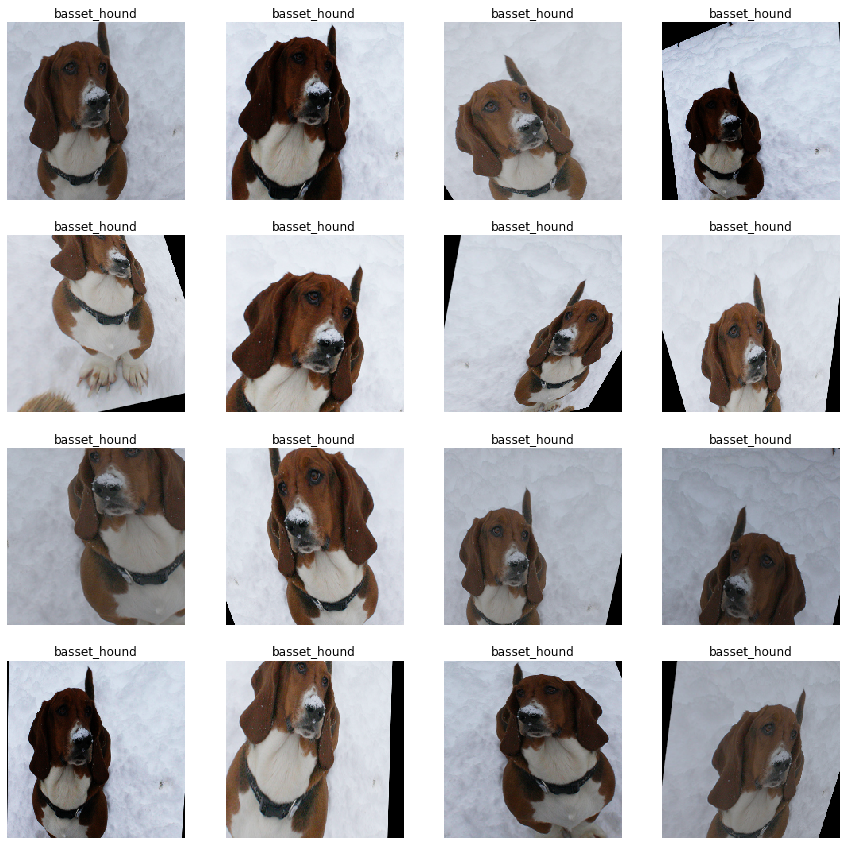

In [15]:
def _plot(i,j,ax):
    x,y = data.train_ds[2]
    x.show(ax, y=y)

plot_multi(_plot, 4, 4, figsize=(15,15))

In [16]:
data = get_data(224,bs)

In [26]:
data.train_ds[2]

(Image (3, 224, 224), Category basset_hound)

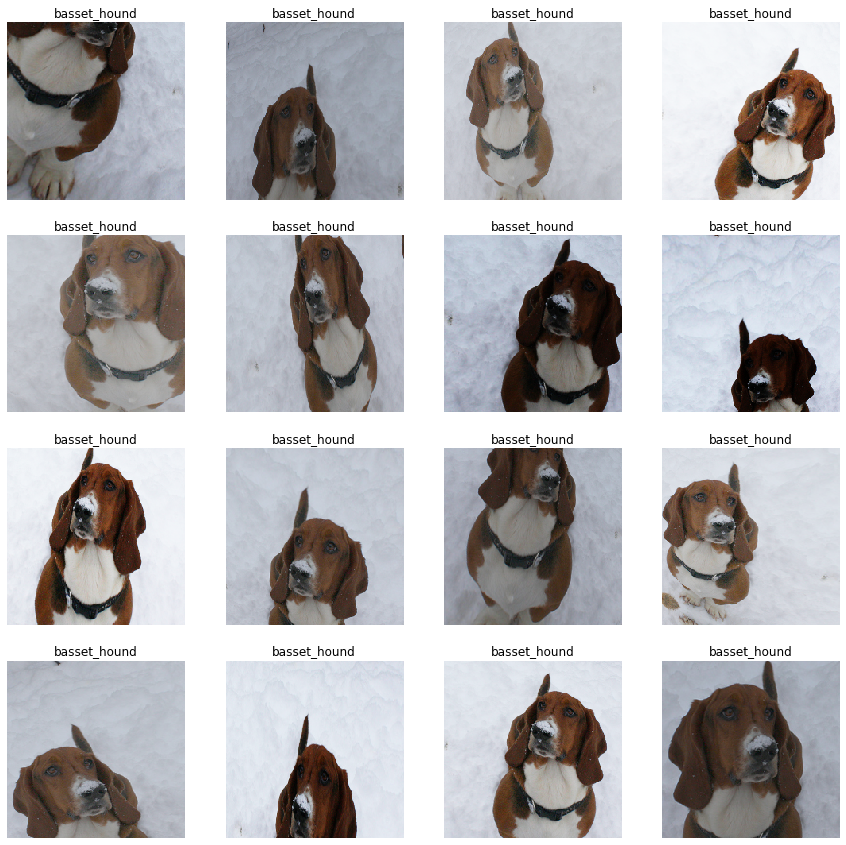

In [18]:
plot_multi(_plot, 4, 4, figsize=(15,15))

## Train a model

In [11]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

In [12]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,1.649129,0.407397,0.100812,00:40
1,0.981547,0.315151,0.093369,00:27
2,0.721121,0.277246,0.074425,00:27


In [13]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.572395,0.277700,0.076455,00:27
1,0.537510,0.265374,0.068336,00:27


In [14]:
data = get_data(352,bs)
learn.data = data

In [15]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.513430,0.242721,0.064276,00:49
1,0.486982,0.237554,0.060217,00:50


In [16]:
learn.save('352')

## Convolution kernel

In [19]:
data = get_data(352,16)

In [20]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

Category american_bulldog

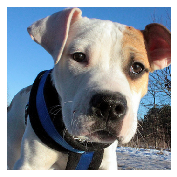

In [38]:
idx=5
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [39]:
k = tensor([
    [0.  ,-5/3,1],
    [-5/3,-5/3,1],
    [1.  ,1   ,1],
]).expand(1,3,3,3)/6


k1 = tensor([
    [1.   ,2.   ,1],
    [0.   ,0    ,0],
    [-1.  ,-2   ,-1],
]).expand(1,3,3,3)/6

k2 = tensor([
    [1.   ,2.   ,1],
    [0.   ,0    ,0],
    [-1.  ,-2   ,-1],
]).T.expand(1,3,3,3)/6


In [40]:
k.sum(0)
k1.sum(0)
k2.sum(0)

tensor([[[ 0.1667,  0.0000, -0.1667],
         [ 0.3333,  0.0000, -0.3333],
         [ 0.1667,  0.0000, -0.1667]],

        [[ 0.1667,  0.0000, -0.1667],
         [ 0.3333,  0.0000, -0.3333],
         [ 0.1667,  0.0000, -0.1667]],

        [[ 0.1667,  0.0000, -0.1667],
         [ 0.3333,  0.0000, -0.3333],
         [ 0.1667,  0.0000, -0.1667]]])

In [41]:
k1.shape

torch.Size([1, 3, 3, 3])

In [45]:
t = data.valid_ds[idx][0].data; t.shape

torch.Size([3, 352, 352])

In [46]:
t[None].shape

torch.Size([1, 3, 352, 352])

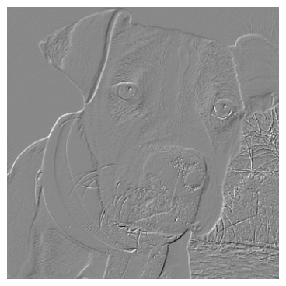

In [47]:
edge = F.conv2d(t[None], k)
show_image(edge[0], figsize=(5,5));

In [48]:
edge.shape

torch.Size([1, 1, 350, 350])

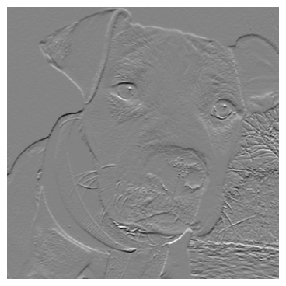

In [49]:
edge = F.conv2d(t[None], k1)
show_image(edge[0], figsize=(5,5));

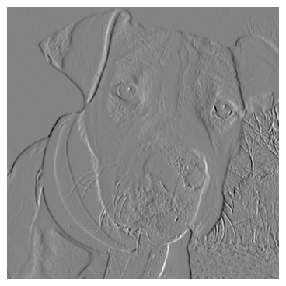

In [50]:
edge = F.conv2d(t[None], k2)
show_image(edge[0], figsize=(5,5));

In [52]:
data.c

37

In [53]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [54]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

## Heatmap

In [55]:
m = learn.model.eval();

In [56]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [57]:
from fastai.callbacks.hooks import *

In [58]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [59]:
hook_a,hook_g = hooked_backward()

In [60]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [61]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [62]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

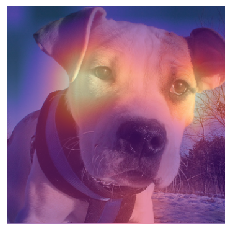

In [63]:
show_heatmap(avg_acts)

## Grad-CAM

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [64]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [65]:
mult = (acts*grad_chan[...,None,None]).mean(0)

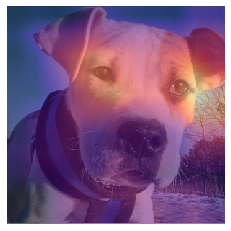

In [66]:
show_heatmap(mult)

In [78]:
fn = path/'yorkshire_terrier_96.jpg' #Replace with your own image

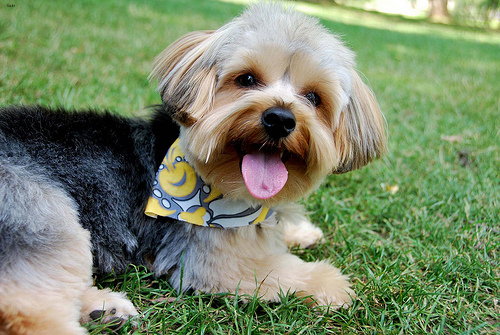

In [79]:
x = open_image(fn); x

In [80]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [81]:
hook_a,hook_g = hooked_backward()

In [82]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

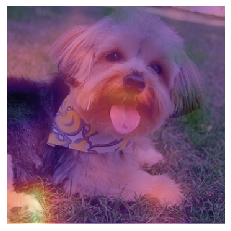

In [83]:
show_heatmap(mult)

In [84]:
data.classes[0]

'Abyssinian'

In [85]:
hook_a,hook_g = hooked_backward(0)

In [86]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

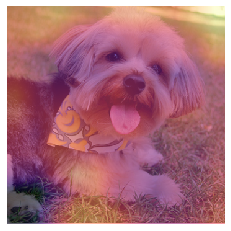

In [87]:
show_heatmap(mult)

## fin